In [1]:
import os


os.chdir('../../Data/')
os.getcwd()



'c:\\Users\\Nick\\.aProject\\Project ETA\\Github\\Data'

In [2]:

# Developed in other notebook
lex_db = 'C:\\Users\\Nick\\Documents\\UVA\\DSI\\Spring 2019\\ETA\\Github Repo ETA\\DS5559\\labs\\2019-04-11_Lab11\\lexicons.db'

# Developed in previous lab
OHCO = ['year','month','day','section', 'doc_id', 'sentence_num']
YEAR = OHCO[:1]
MONTH = OHCO[:2]
DATE = OHCO[:3]
SECT = OHCO[:4]
ARTICLE = OHCO[:5]
SENTS = OHCO[:6]

# emo = 'bing_sentiment'
emo = 'syu_sentiment'

# For KDE
kde_kernel = 'gaussian'
# kde_bandwidth = 100
kde_samples = 1000


In [3]:
import pandas as pd
import numpy as np
import scipy as sp
import sys
import scipy.fftpack as fftpack
from sklearn.neighbors import KernelDensity as KDE
from sklearn.preprocessing import scale

import sqlite3

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display, HTML


In [4]:

get_ipython().run_line_magic('matplotlib', 'inline')
sns.set()
plt.style.use('fivethirtyeight')


In [5]:
with sqlite3.connect(lex_db) as db:
    combo = pd.read_sql('SELECT * FROM combo', db, index_col='term_str')



In [6]:
combo.head()


,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,syu_sentiment,gi_sentiment
term_str,,,,,,,,,,,,,,,
abandon,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,-0.75,-1.0
abandoned,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,-0.50,NaN
abandoner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.25,NaN
abandonment,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,-0.25,-1.0
abandons,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.00,NaN


In [7]:
# emo_cols = [col for col in combo.columns if 'nrc_' in col]
emo_cols = combo.columns



In [8]:
emo_cols


Index(['nrc_anger', 'nrc_anticipation', 'nrc_disgust', 'nrc_fear', 'nrc_joy',
       'nrc_negative', 'nrc_positive', 'nrc_sadness', 'nrc_surprise',
       'nrc_trust', 'bing_negative', 'bing_positive', 'bing_sentiment',
       'syu_sentiment', 'gi_sentiment'],
      dtype='object')

In [9]:

tokens = pd.read_csv("redo_token_mod.csv")
tokens = tokens[~tokens.term_str.isna()]
vocab = pd.read_csv("redo_vocab.csv", index_col='term_id')
docs = pd.read_csv("redo_doc.csv")
# just renaming so I can delete items
full_tokens = pd.merge(tokens, docs, on='doc_id')
del(tokens)
tokens = full_tokens
tokens.set_index(OHCO)



token_id  token_num  \
year month day section    doc_id sentence_num                        
1999 1     4   NaN        0      0                    0          0   
                                 0                    1          1   
                                 0                    2          2   
                                 0                    3          3   
                                 0                    4          4   
                                 0                    5          5   
                                 0                    7          7   
                                 0                    8          8   
                                 0                    9          9   
                                 1                   11          0   
                                 1                   12          1   
                                 1                   13          2   
                                 1                   14          3   
                                 1                   15          4   
                                 1                   16          5   
                                 1                   17          6   
                                 1                   18          7   
                                 1                   20          9   
                                 1                   21         10   
                                 1                   22         11   
                                 1                   23         12   
                                 1                   24         13   
                                 1                   26         15   
                                 1                   27         16   
                                 1                   28         17   
                                 1                   29         18   
                                 1                   30         19   
                                 1                   31         20   
                                 1                   32         21   
                                 1                   33         22   
...                                                 ...        ...   
2002 12    31  World-Wide 124033 32            79135804         16   
                                 32            79135805         17   
                                 32            79135806         18   
                                 32            79135807         19   
                                 32            79135808         20   
                                 32            79135809         21   
                                 32            79135810         22   
                                 32            79135811         23   
                                 32            79135812         24   
                                 32            79135813         25   
                                 32            79135814         26   
                                 32            79135815         27   
                                 32            79135816         28   
                                 32            79135817         29   
                                 32            79135819         31   
                                 32            79135820         32   
                                 33            79135822          0   
                                 33            79135823          1   
                                 33            79135824          2   
                                 33            79135825          3   
                                 33            79135826          4   
                                 33            79135827          5   
                                 33            79135828          6   
                                 33            79135829          7   
                                 33            79135830  

In [10]:
tokens = tokens.join(combo, on='term_str', how='left')



In [11]:
tokens[emo].sample(10)



6031495     NaN
67368275    NaN
44267995    NaN
15299686    1.0
35486584    NaN
53144349    NaN
71685596    NaN
45255454    NaN
13041330    NaN
23045790    NaN
Name: syu_sentiment, dtype: float64

In [12]:
tokens[emo_cols] = tokens[emo_cols].fillna(0)



In [13]:
tokens.head(10)


,token_id,sentence_num,token_num,token_str,term_str,term_id,punc,num,doc_id,year,...,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,syu_sentiment,gi_sentiment
0,0,0,0,Year-End,yearend,355866,0,0,0,1999,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,1,Review,review,268966,0,0,0,1999,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0,2,of,of,225053,0,0,0,1999,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0,3,Markets,markets,191312,0,0,0,1999,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0
4,4,0,4,and,and,11289,0,0,0,1999,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,5,0,5,Finance,finance,110543,0,0,0,1999,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,7,0,7,What,what,348808,0,0,0,1999,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,8,0,8,Was,was,345213,0,0,0,1999,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,9,0,9,News,news,216286,0,0,0,1999,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,11,1,0,Corrections,corrections,67540,0,0,0,1999,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
FIG = dict(figsize=(20, 5), legend=True, fontsize=14, rot=45)


C:\Users\Nick\Anaconda2\envs\py35\lib\site-packages\pandas\core\indexes\multi.py:1565: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if lab[key] == -1:
C:\Users\Nick\Anaconda2\envs\py35\lib\site-packages\pandas\core\indexes\multi.py:1568: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  retval.append(lev[lab[key]])
C:\Users\Nick\Anaconda2\envs\py35\lib\site-packages\pandas\core\indexes\multi.py:1565: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if lab[key] == -1:
C:\Users\Nick\Anaconda2\envs\py35\lib\site-packages\pandas\core\indexes\multi.py:1568: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  retval.append(lev[lab[key]])
C:\Users\Nick\Anaconda2\envs\py35\lib\site-packages\pandas\core\indexes\multi.py:1565: Visib

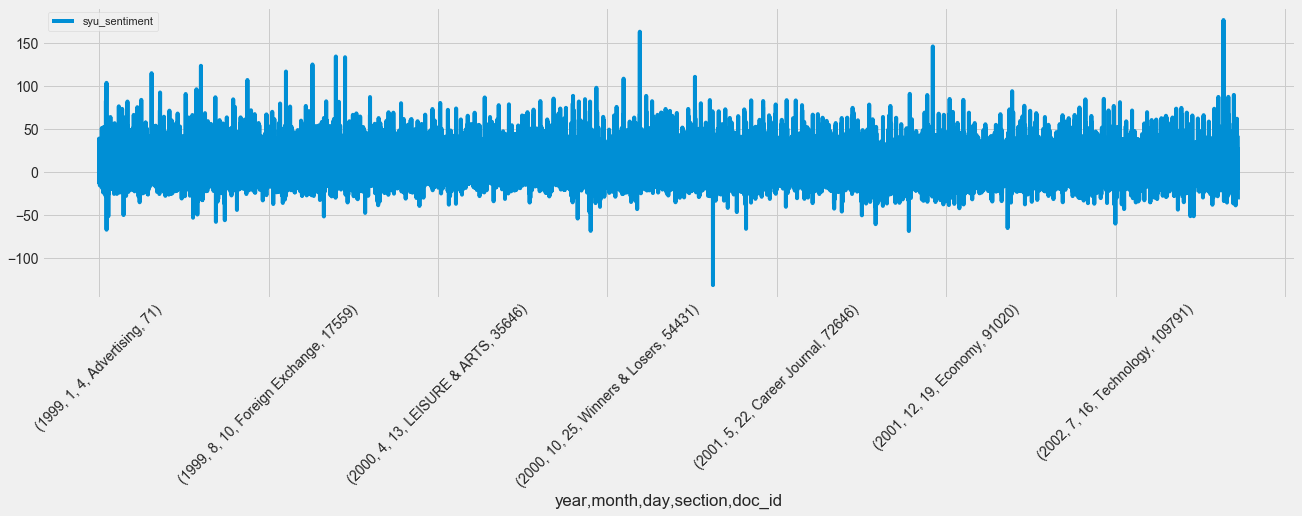

In [15]:
by_article = tokens.groupby(ARTICLE)[emo].sum().plot(**FIG)


In [16]:
by_date = tokens.groupby(DATE)[emo_cols].sum()



In [17]:
max_x = by_date.shape[0]
xticks = list(range(0, max_x, 100))
xticks.append(max_x - 1)



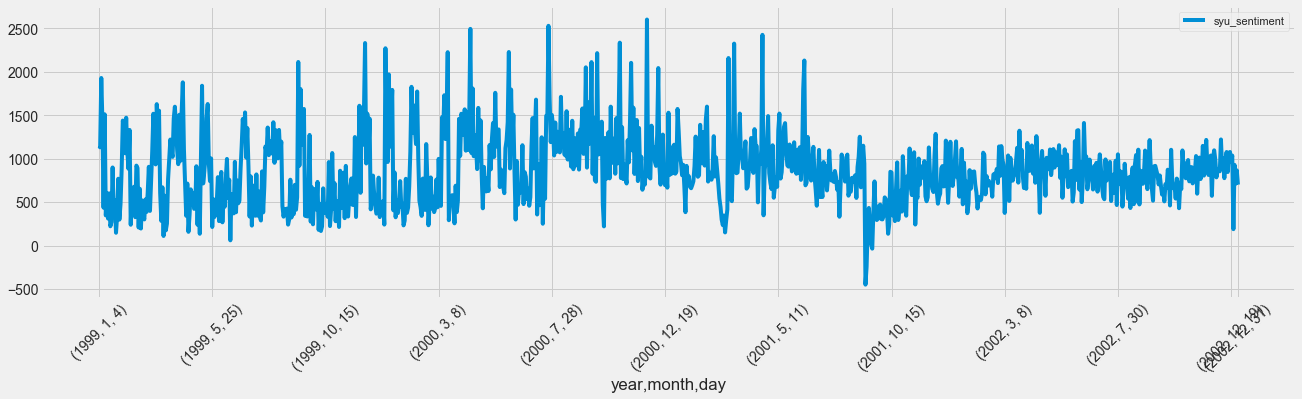

In [18]:
by_date[emo].plot(**FIG, xticks=xticks)


In [19]:
by_month = tokens.groupby(MONTH)[emo_cols].sum()



In [20]:
max_x = by_month.shape[0]
xticks = list(range(0, max_x, 250))
xticks.append(max_x - 1)



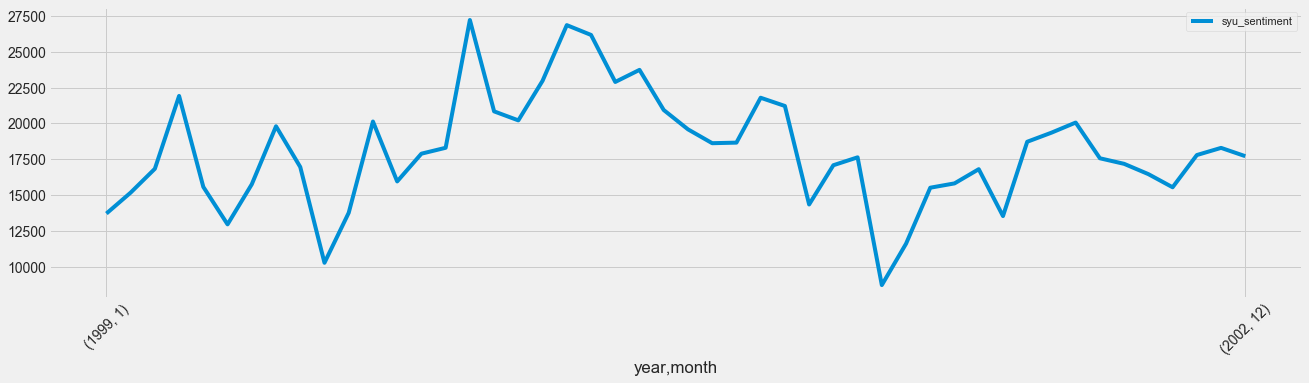

In [21]:
by_month[emo].plot(**FIG, xticks=xticks)

In [22]:
by_month['month_str'] = tokens.groupby(MONTH).term_str.apply(lambda x: x.str.cat(sep=' '))
#by_month['html_str'] = tokens.groupby(MONTH).html.apply(lambda x: x.str.cat(sep=' '))



In [23]:
by_month[['month_str']].head()


month_str
year month                                                   
1999 1      yearend review of markets and finance what was...
     2      closedend funds voyageur az vaz a or voyageur ...
     3      patriot plans name change ceo to resign by nea...
     4      gdp chart us economic growth as measured by gr...
     5      corporate performance review quarter latest pr...

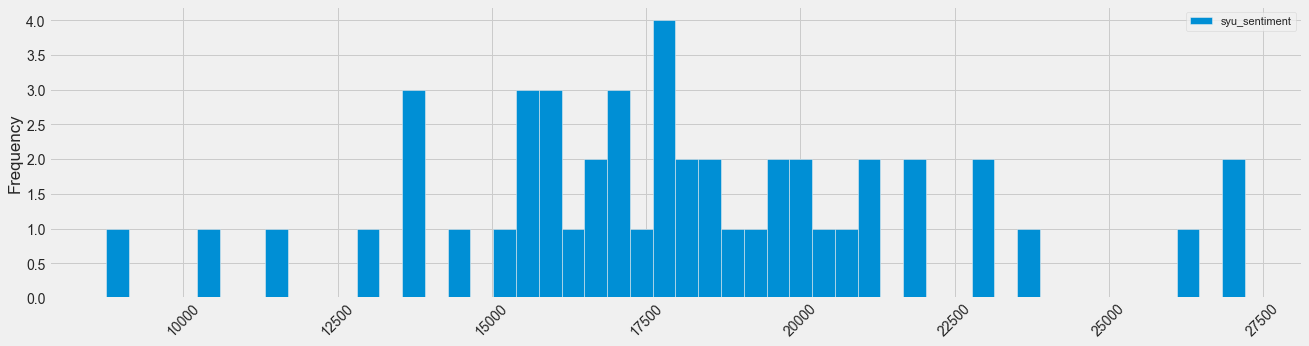

In [26]:
by_month[emo].plot.hist(**FIG, bins=50)


In [27]:
xticks = [0]
xticks += by_month[emo].reset_index().sort_values(emo).head(7).index.values.tolist()
xticks += by_month[emo].reset_index().sort_values(emo).tail(7).index.values.tolist()
xticks += [by_month.shape[0] - 1]



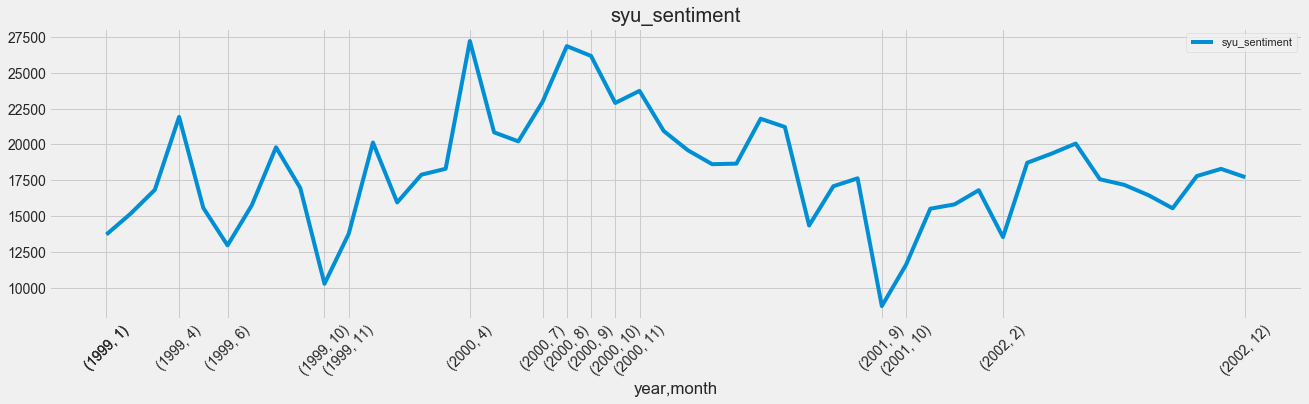

In [28]:
by_month[emo].plot(**FIG, xticks=xticks, title=emo)



In [29]:
by_month.iloc[xticks][emo].sort_index().to_frame()


syu_sentiment
year month               
1999 1           13729.00
     1           13729.00
     4           21918.40
     6           12975.60
     10          10300.05
     11          13781.80
2000 4           27207.05
     7           22973.90
     8           26848.25
     9           26165.55
     10          22892.25
     11          23732.85
2001 9            8747.85
     10          11629.55
2002 2           13553.40
     12          17723.20

In [30]:
by_month.sort_values(emo, ascending=False)[[emo,'month_str']].head(20)


syu_sentiment                                          month_str
year month                                                                  
2000 4           27207.05  deals and deal makers ipo outlook aftermarket ...
     8           26848.25  firstar pact with first union milwaukee firsta...
     9           26165.55  cache august sales rose percent new york cache...
     11          23732.85  the wall street journal or new england what ne...
     7           22973.90  clinton nominates mineta to be commerce secret...
     10          22892.25  congress may overshoot the gop target for spen...
1999 4           21918.40  gdp chart us economic growth as measured by gr...
2001 4           21792.05  filipino plan for domain name creates a stir m...
     5           21218.85  corrections and amplifications the council of ...
2000 12          20938.15  janitors draw unions support of california sui...
     5           20843.95  secrets are not secure on clinton watch the st...
     6           20216.45  review and outlook editorial those musty wine ...
1999 12          20137.40  cvs reports rise in store sales woonsocket ri ...
2002 5           20065.20  guess hu coming to the white house as hu jinta...
1999 8           19804.85  mcdermott completes purchase new orleans mcder...
2001 1           19592.95  france telecom offer of orange stock to launch...
2002 4           19359.65  quarterly stock market review venture capitali...
     3           18727.55  recent stocklisting changes new york among rec...
2001 3           18666.70  bush first budget some gop lawmakers balk at b...
     2           18627.20  clinton lands a gig a bondcrowd talk for a dol...

In [31]:
by_month.sort_values(emo, ascending=True)[[emo,'month_str']].head(20)


syu_sentiment                                          month_str
year month                                                                  
2001 9            8747.85  hold the oatmeal restaurants now court the bre...
1999 10          10300.05  review and outlook editorial easy on the etax ...
2001 10          11629.55  quarterly stock market review hopes for ventur...
1999 6           12975.60  simmons first national corp pine bluff ark sim...
2002 2           13553.40  letters to the editor argentina legal plunder ...
1999 1           13729.00  yearend review of markets and finance what was...
     11          13781.80  general growth to buy mall chicago general gro...
2001 6           14360.30  nyse highs or lows thursday may time val time ...
1999 2           15185.30  closedend funds voyageur az vaz a or voyageur ...
2001 11          15528.45  money rates wednesday october the key u s and ...
2002 9           15558.70  longshore contract talks fail negotiations for...
1999 5           15583.15  corporate performance review quarter latest pr...
     7           15767.30  wall street underwriting and stock performance...
2001 12          15828.45  fall of a power giant spotlight put on creditd...
2000 1           15964.85  money rates friday december the key u s and fo...
2002 8           16473.40  fasb may consider tightening stockoption accou...
     1           16817.50  coming to america rybnitsa moldova here is whe...
1999 3           16845.90  patriot plans name change ceo to resign by nea...
     9           16970.60  the wall street journal or california we can e...
2001 7           17092.85  in a turnabout nature group cries timber by qu...

In [33]:
def get_dct_transform(raw_values, low_pass_size = 5, x_reverse_len = 100):
    if low_pass_size > len(raw_values):
        raise ValueError("low_pass_size must be less than or equal to the length of raw_values input vector")
    values_dct = fftpack.dct(raw_values, type = 2)
    keepers = values_dct[:low_pass_size]
    padded_keepers = list(keepers) + list(np.zeros(x_reverse_len - low_pass_size))
    dct_out = fftpack.idct(padded_keepers)
    return(dct_out)



In [34]:
FFTCFG1 = dict(
    low_pass_size = 5,
    x_reverse_len = 100
)
X1 = get_dct_transform(by_month[emo].values, **FFTCFG1)



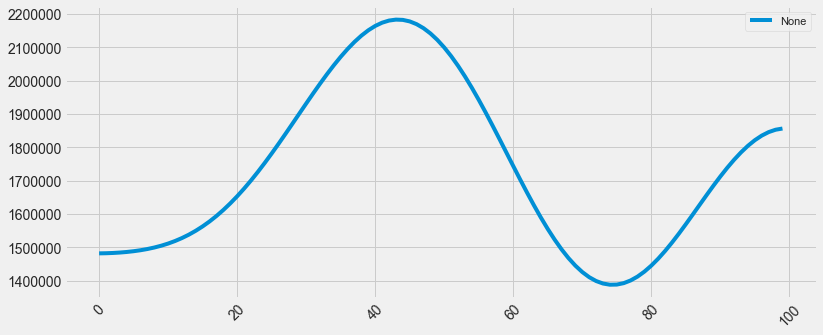

In [35]:
FIG['legend'] = True
FIG['figsize'] = (12,5)
pd.Series(X1).plot(**FIG)


In [43]:
by_month = tokens.groupby(MONTH)['nrc_anger'].sum()



In [45]:
by_month = tokens.groupby(MONTH)[emo_cols].sum()

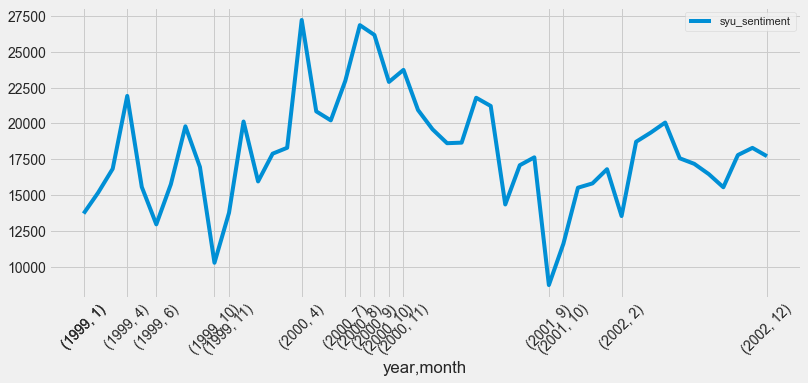

In [46]:
by_month[emo].plot(**FIG, xticks=xticks)

In [48]:
by_month['month_str'] = tokens.groupby(MONTH).term_str.apply(lambda x: x.str.cat(sep=' '))
#by_month['html_str'] = tokens.groupby(MONTH).html.apply(lambda x: x.str.cat(sep=' '))



In [49]:
by_month[['month_str']].head()


month_str
year month                                                   
1999 1      yearend review of markets and finance what was...
     2      closedend funds voyageur az vaz a or voyageur ...
     3      patriot plans name change ceo to resign by nea...
     4      gdp chart us economic growth as measured by gr...
     5      corporate performance review quarter latest pr...

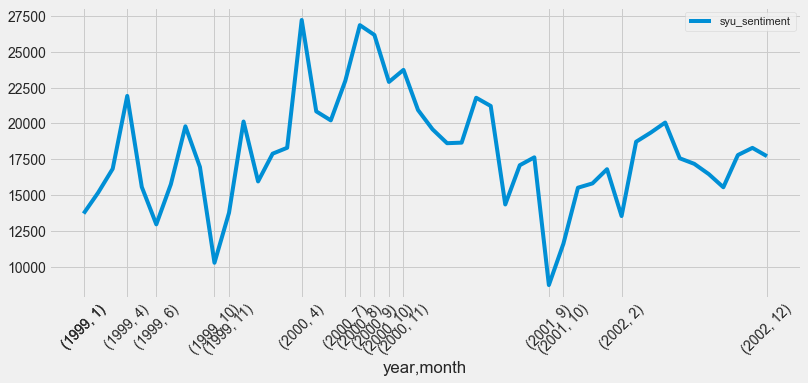

In [51]:
by_month[emo].plot(**FIG, xticks=xticks)

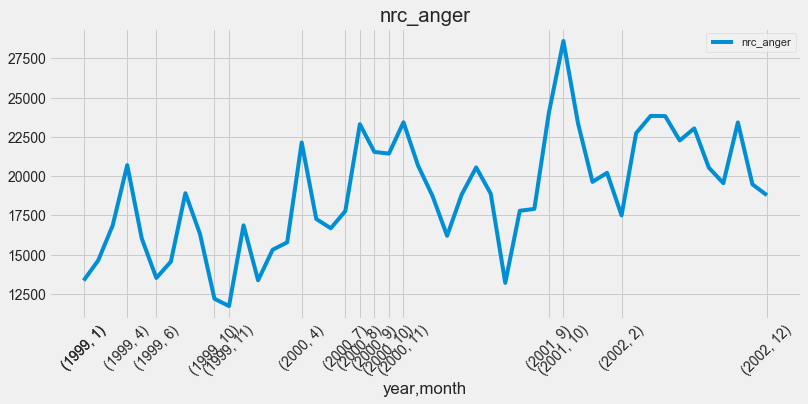

In [56]:
by_month['nrc_anger'].plot(**FIG, xticks=xticks, title = 'nrc_anger')

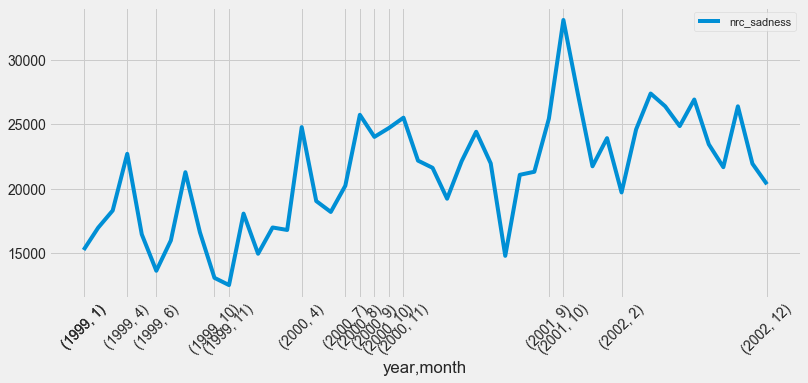

In [57]:
by_month['nrc_sadness'].plot(**FIG, xticks=xticks)

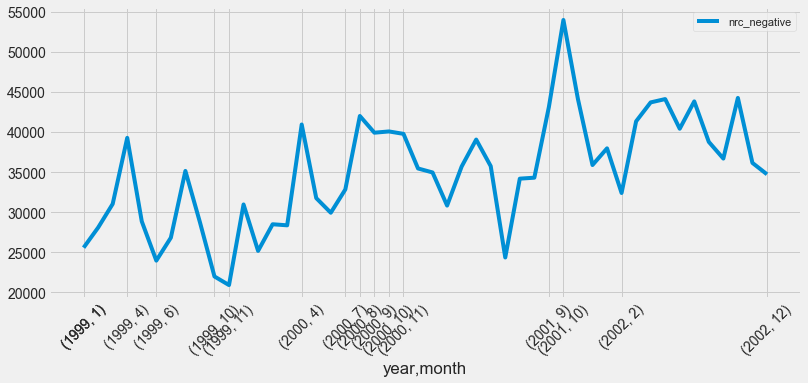

In [58]:
by_month['nrc_negative'].plot(**FIG, xticks=xticks)

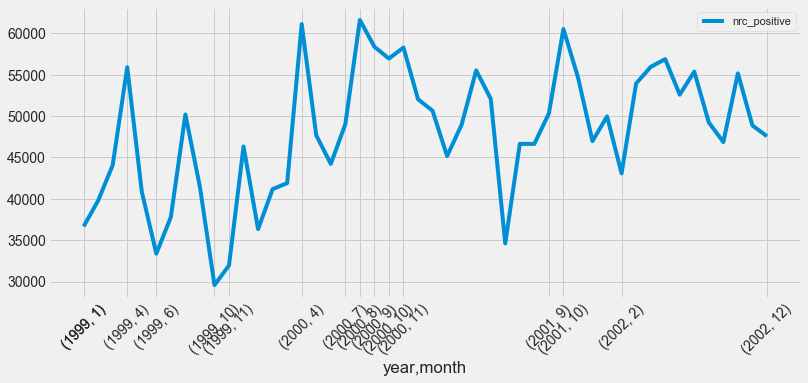

In [59]:
by_month['nrc_positive'].plot(**FIG, xticks=xticks)

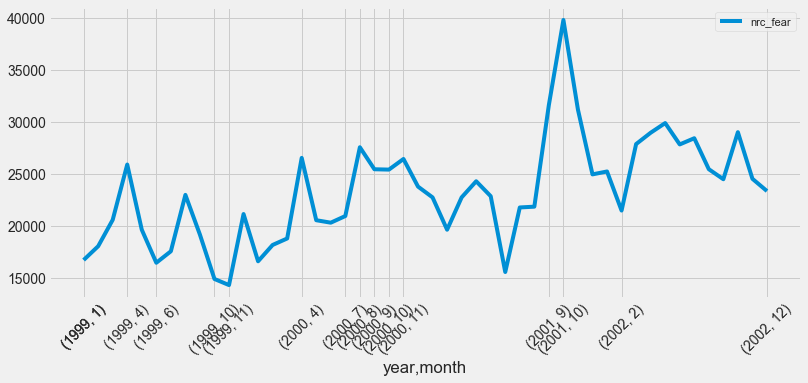

In [60]:
by_month['nrc_fear'].plot(**FIG, xticks=xticks)

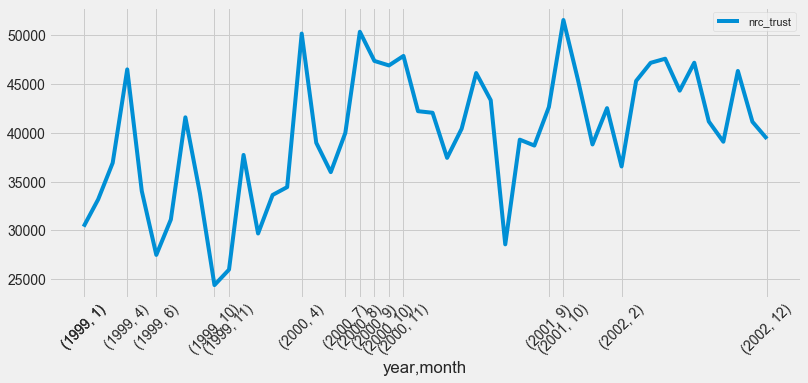

In [61]:
by_month['nrc_trust'].plot(**FIG, xticks=xticks)

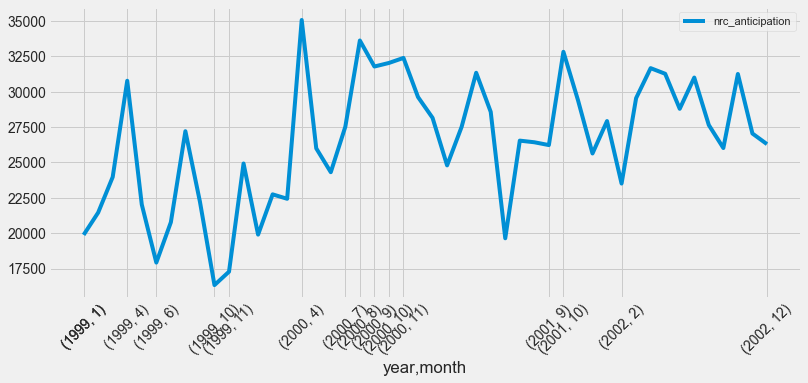

In [62]:
by_month['nrc_anticipation'].plot(**FIG, xticks=xticks)

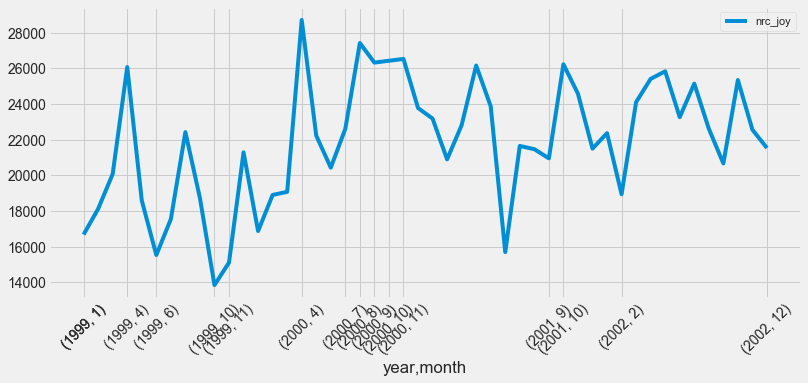

In [63]:
by_month['nrc_joy'].plot(**FIG, xticks=xticks)

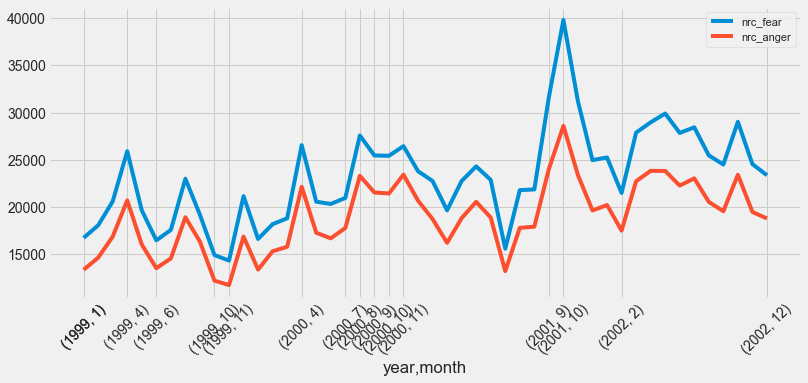

In [66]:
by_month['nrc_fear'].plot(**FIG, xticks=xticks)
by_month['nrc_anger'].plot(**FIG, xticks=xticks)


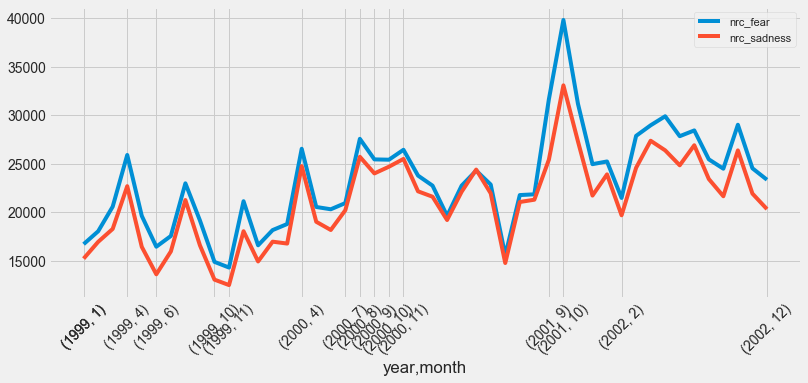

In [69]:
by_month['nrc_fear'].plot(**FIG, xticks=xticks)
by_month['nrc_sadness'].plot(**FIG, xticks=xticks)



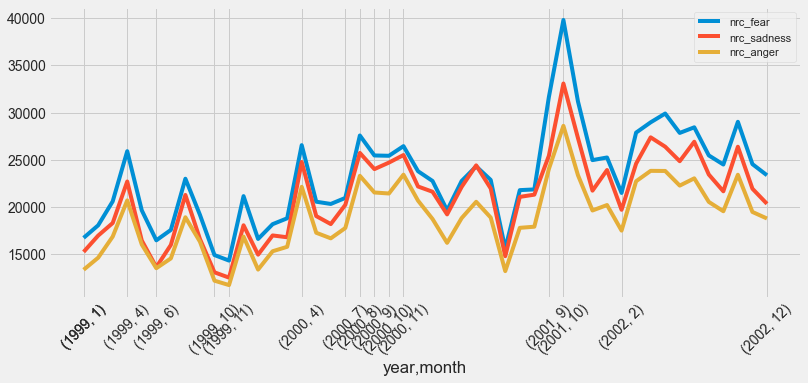

In [70]:
by_month['nrc_fear'].plot(**FIG, xticks=xticks)
by_month['nrc_sadness'].plot(**FIG, xticks=xticks)
by_month['nrc_anger'].plot(**FIG, xticks=xticks)



In [74]:
by_month = tokens.groupby(SECT)[emo_cols].sum()

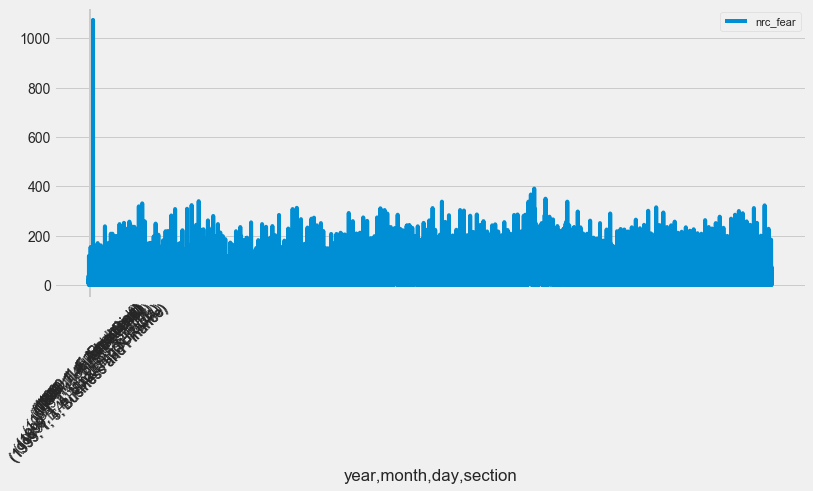

In [75]:
by_month['nrc_fear'].plot(**FIG, xticks=xticks)

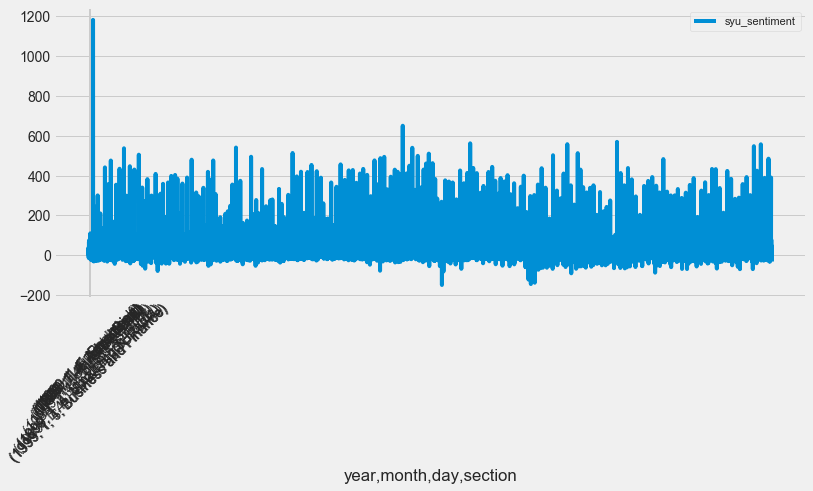

In [79]:
by_month[emo].plot(**FIG, xticks=xticks)


In [81]:
by_month = tokens.groupby(MONTH)[emo_cols].sum()

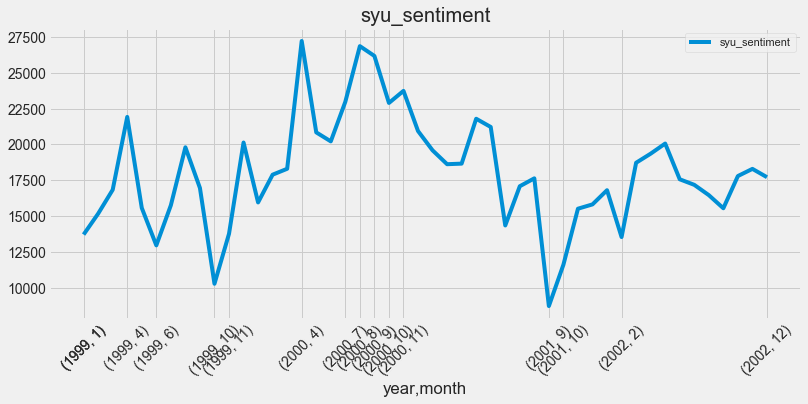

In [82]:
by_month[emo].plot(**FIG, xticks=xticks, title=emo)



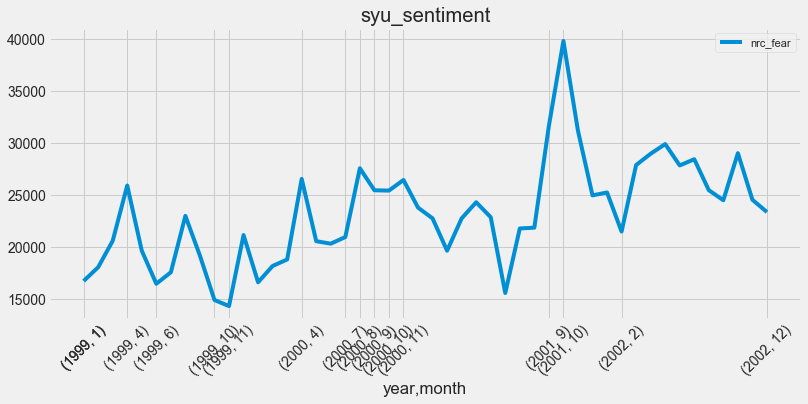

In [84]:
by_month['nrc_fear'].plot(**FIG, xticks=xticks, title=emo)



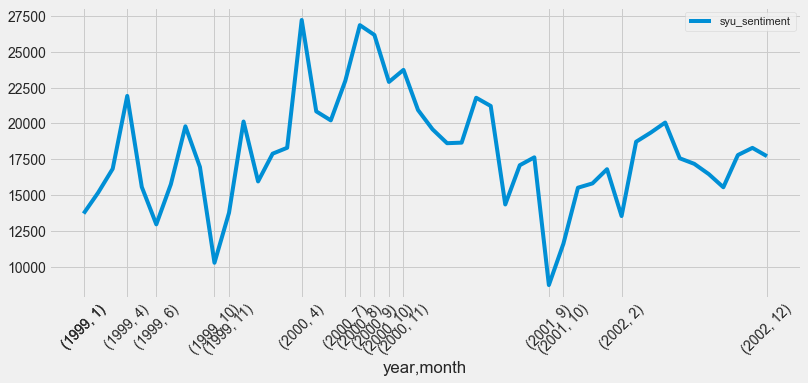

In [86]:
by_month[emo].plot(**FIG, xticks=xticks)



In [89]:
emo_cols

Index(['nrc_anger', 'nrc_anticipation', 'nrc_disgust', 'nrc_fear', 'nrc_joy',
       'nrc_negative', 'nrc_positive', 'nrc_sadness', 'nrc_surprise',
       'nrc_trust', 'bing_negative', 'bing_positive', 'bing_sentiment',
       'syu_sentiment', 'gi_sentiment'],
      dtype='object')

In [94]:
tokens[tokens.section=="International"]

,token_id,sentence_num,token_num,token_str,term_str,term_id,punc,num,doc_id,year,...,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,syu_sentiment,gi_sentiment
72332,81087,0,0,Slowdown,slowdown,294128,0,0,94,1999,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
72333,81088,0,1,Could,could,68324,0,0,94,1999,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
72334,81089,0,2,Chill,chill,54247,0,0,94,1999,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,-0.10,0.0
72335,81090,0,3,Currency,currency,72567,0,0,94,1999,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
72336,81091,0,4,Infant,infant,153144,0,0,94,1999,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.60,0.0
72337,81092,0,5,Days,days,75990,0,0,94,1999,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
72338,81093,0,6,By,by,43749,0,0,94,1999,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
72339,81094,0,7,David,david,75762,0,0,94,1999,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
72340,81095,0,8,Woodruff,woodruff,352651,0,0,94,1999,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
72341,81096,0,9,Staff,staff,301808,0,0,94,1999,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0


C:\Users\Nick\Anaconda2\envs\py35\lib\site-packages\pandas\core\indexes\multi.py:1565: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if lab[key] == -1:
C:\Users\Nick\Anaconda2\envs\py35\lib\site-packages\pandas\core\indexes\multi.py:1568: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  retval.append(lev[lab[key]])
C:\Users\Nick\Anaconda2\envs\py35\lib\site-packages\pandas\core\indexes\multi.py:1565: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if lab[key] == -1:
C:\Users\Nick\Anaconda2\envs\py35\lib\site-packages\pandas\core\indexes\multi.py:1568: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  retval.append(lev[lab[key]])
C:\Users\Nick\Anaconda2\envs\py35\lib\site-packages\pandas\core\indexes\multi.py:1565: Visib

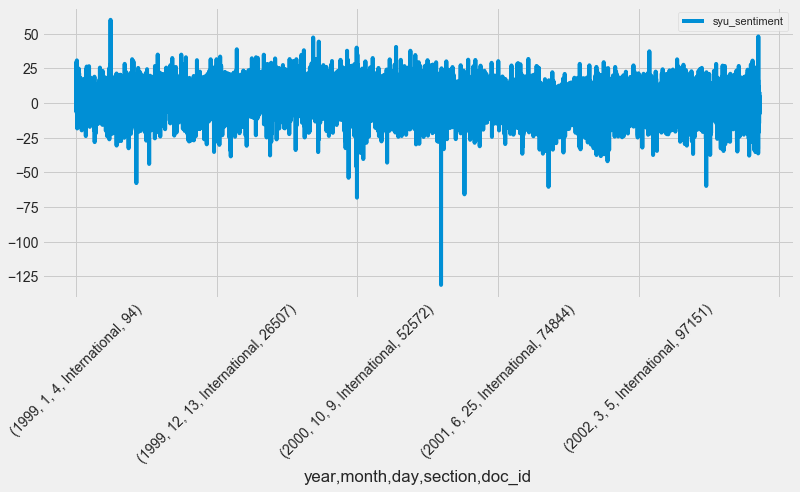

In [95]:
by_internationalmonth = tokens[tokens.section=="International"].groupby(ARTICLE)[emo].sum().plot(**FIG)

C:\Users\Nick\Anaconda2\envs\py35\lib\site-packages\pandas\core\indexes\multi.py:1565: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if lab[key] == -1:
C:\Users\Nick\Anaconda2\envs\py35\lib\site-packages\pandas\core\indexes\multi.py:1568: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  retval.append(lev[lab[key]])
C:\Users\Nick\Anaconda2\envs\py35\lib\site-packages\pandas\core\indexes\multi.py:1565: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if lab[key] == -1:
C:\Users\Nick\Anaconda2\envs\py35\lib\site-packages\pandas\core\indexes\multi.py:1568: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  retval.append(lev[lab[key]])
C:\Users\Nick\Anaconda2\envs\py35\lib\site-packages\pandas\core\indexes\multi.py:1565: Visib

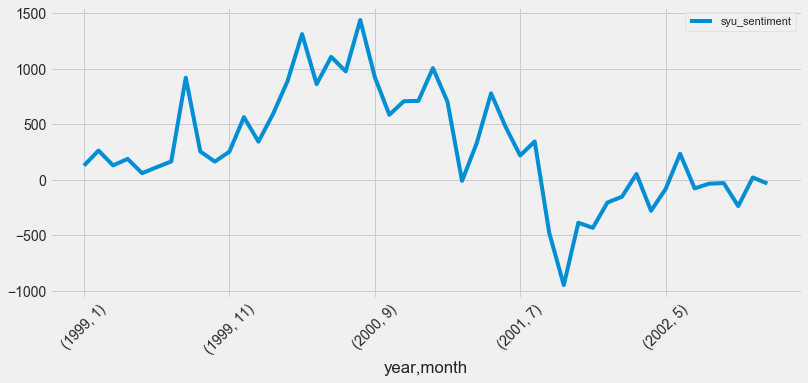

In [96]:

by_internationalmonth = tokens[tokens.section=="International"].groupby(MONTH)[emo].sum().plot(**FIG)


In [97]:
by_internationalmonth[emo].plot(**FIG, xticks=xticks)

TypeError: 'AxesSubplot' object is not subscriptable

In [98]:
max_x = by_internationalmonth.shape[0]
xticks = list(range(0, max_x, 100))
xticks.append(max_x - 1)

AttributeError: 'AxesSubplot' object has no attribute 'shape'

In [99]:
by_internationalmonth.shape[0]

AttributeError: 'AxesSubplot' object has no attribute 'shape'

In [100]:
by_internationalmonth

In [101]:

by_internationalmonth = tokens[tokens.section=="International"].groupby(MONTH)[emo].sum()

In [102]:
max_x = by_internationalmonth.shape[0]
xticks = list(range(0, max_x, 100))
xticks.append(max_x - 1)


In [104]:
by_internationalmonth.head()

year  month
1999  1        128.30
      2        263.70
      3        129.95
      4        188.55
      5         59.65
Name: syu_sentiment, dtype: float64

In [105]:
by_internationalmonth = tokens[tokens.section=="International"].groupby(MONTH)[emo_cols].sum()

In [106]:
max_x = by_internationalmonth.shape[0]
xticks = list(range(0, max_x, 100))
xticks.append(max_x - 1)


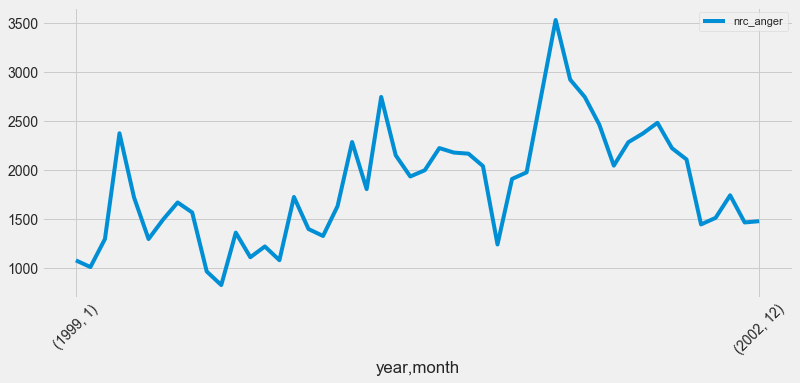

In [107]:
by_internationalmonth['nrc_anger'].plot(**FIG, xticks=xticks)

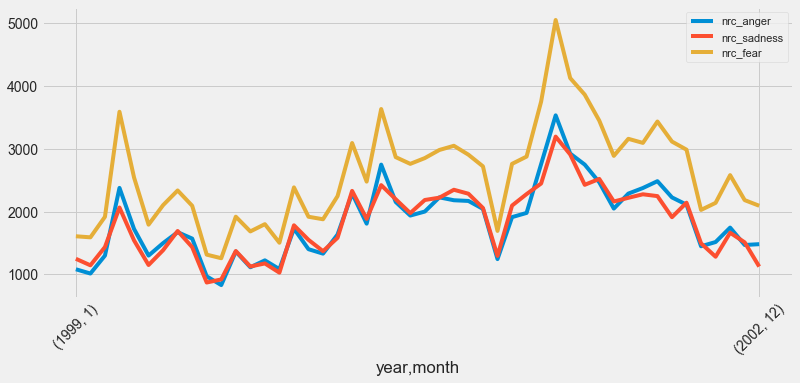

In [108]:
by_internationalmonth['nrc_anger'].plot(**FIG, xticks=xticks)
by_internationalmonth['nrc_sadness'].plot(**FIG, xticks=xticks)
by_internationalmonth['nrc_fear'].plot(**FIG, xticks=xticks)

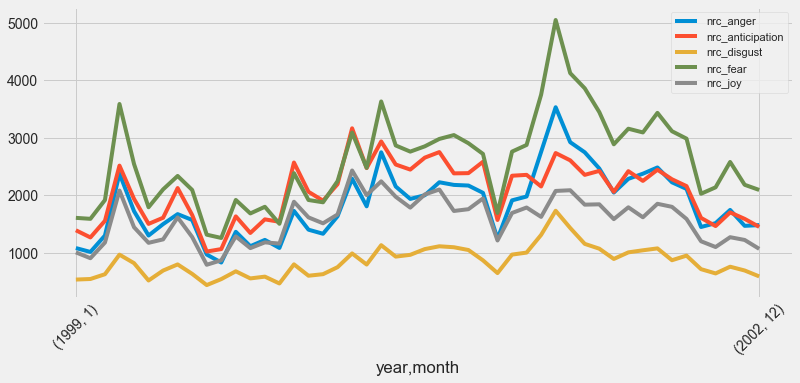

In [111]:

by_internationalmonth[emo_cols[:5]].plot(**FIG, xticks=xticks)


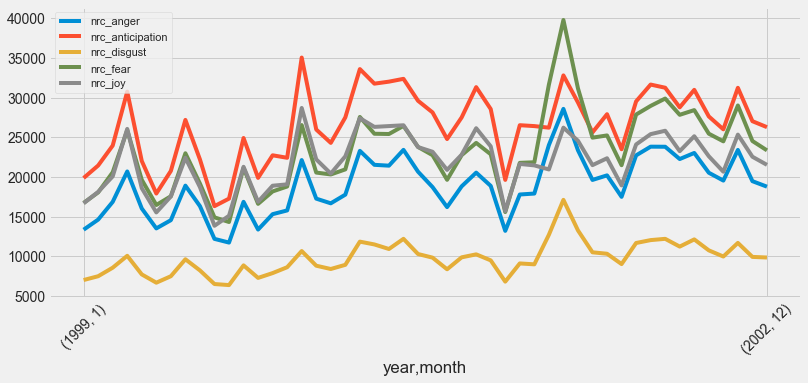

In [112]:
by_month[emo_cols[:5]].plot(**FIG, xticks=xticks)


In [113]:
by_politicsmonth = tokens[tokens.section=="Politics & Policy"].groupby(MONTH)[emo_cols].sum()

max_x = by_politicsmonth.shape[0]
xticks = list(range(0, max_x, 100))
xticks.append(max_x - 1)

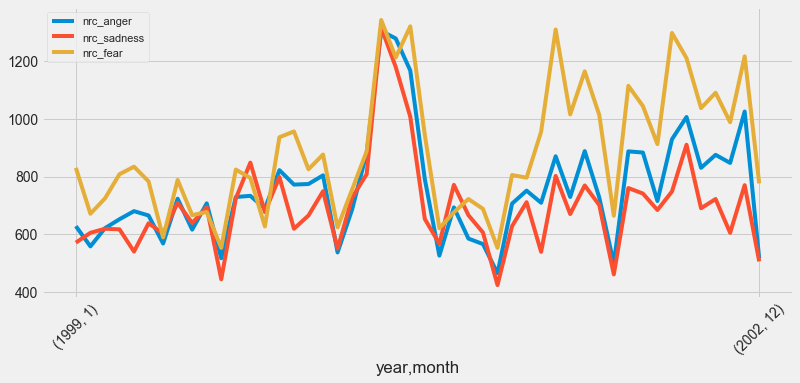

In [114]:
by_politicsmonth['nrc_anger'].plot(**FIG, xticks=xticks)
by_politicsmonth['nrc_sadness'].plot(**FIG, xticks=xticks)
by_politicsmonth['nrc_fear'].plot(**FIG, xticks=xticks)

In [115]:
max_x = by_politicsmonth.shape[0]
xticks = list(range(0, max_x, 48))
xticks.append(max_x - 1)


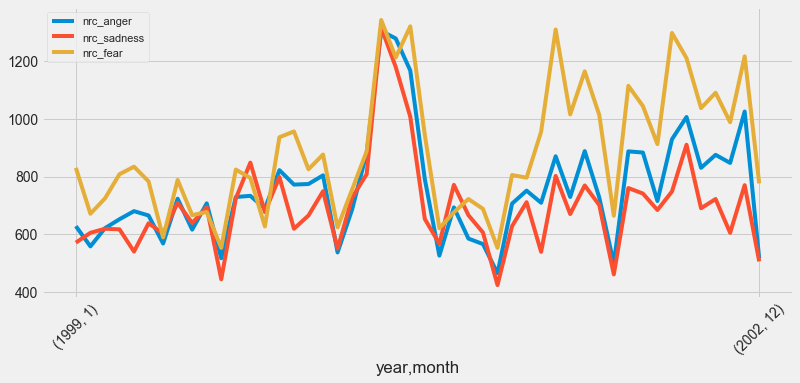

In [116]:
by_politicsmonth['nrc_anger'].plot(**FIG, xticks=xticks)
by_politicsmonth['nrc_sadness'].plot(**FIG, xticks=xticks)
by_politicsmonth['nrc_fear'].plot(**FIG, xticks=xticks)

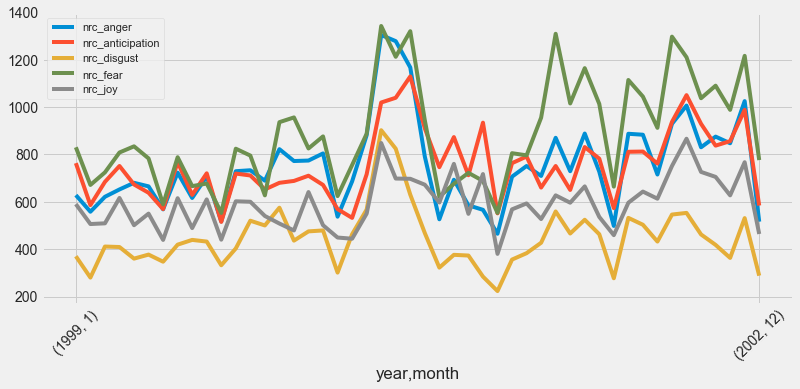

In [118]:
by_politicsmonth[emo_cols[:5]].plot(**FIG, xticks=xticks)

In [119]:
by_techonologymonth = tokens[tokens.section=="techonology].groupby(MONTH)[emo_cols].sum()

max_x = by_techonologymonth.shape[0]
xticks = list(range(0, max_x, 48))
xticks.append(max_x - 1)


SyntaxError: EOL while scanning string literal (<ipython-input-119-3feddff3cf4c>, line 1)

In [120]:
by_techonologymonth = tokens[tokens.section=="Techonology"].groupby(MONTH)[emo_cols].sum()

max_x = by_techonologymonth.shape[0]
xticks = list(range(0, max_x, 48))
xticks.append(max_x - 1)


In [121]:
by_techonologymonth['nrc_anger'].plot(**FIG, xticks=xticks)
by_techonologymonth['nrc_sadness'].plot(**FIG, xticks=xticks)
by_techonologymonth['nrc_fear'].plot(**FIG, xticks=xticks)

TypeError: Empty 'DataFrame': no numeric data to plot

In [122]:
by_technologymonth = tokens[tokens.section=="Technology"].groupby(MONTH)[emo_cols].sum()

max_x = by_technologymonth.shape[0]
xticks = list(range(0, max_x, 48))
xticks.append(max_x - 1)

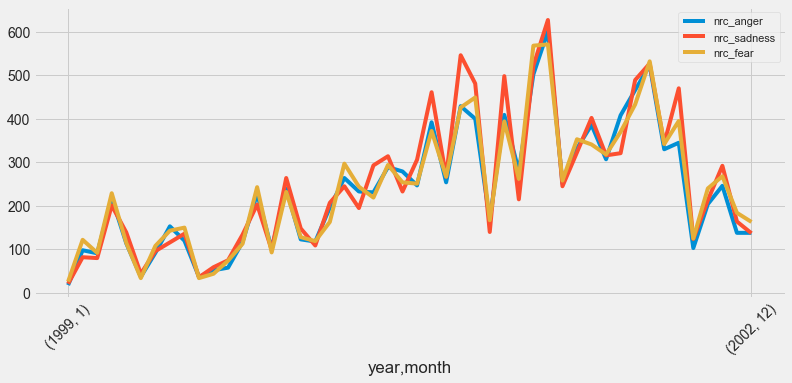

In [123]:
by_technologymonth['nrc_anger'].plot(**FIG, xticks=xticks)
by_technologymonth['nrc_sadness'].plot(**FIG, xticks=xticks)
by_technologymonth['nrc_fear'].plot(**FIG, xticks=xticks)

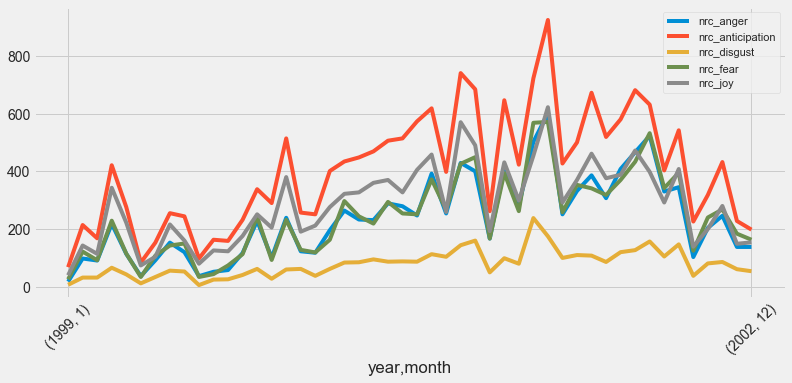

In [124]:
by_technologymonth[emo_cols[:5]].plot(**FIG, xticks=xticks)

In [125]:
by_Economymonth = tokens[tokens.section=="Economy"].groupby(MONTH)[emo_cols].sum()

max_x = by_Economymonth.shape[0]
xticks = list(range(0, max_x, 48))
xticks.append(max_x - 1)


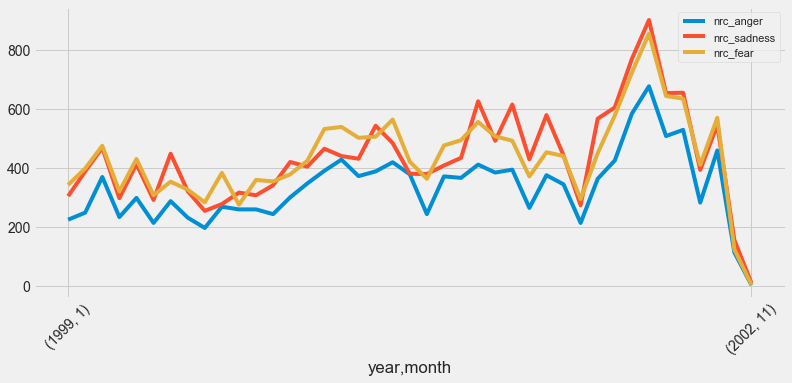

In [126]:
by_Economymonth['nrc_anger'].plot(**FIG, xticks=xticks)
by_Economymonth['nrc_sadness'].plot(**FIG, xticks=xticks)
by_Economymonth['nrc_fear'].plot(**FIG, xticks=xticks)

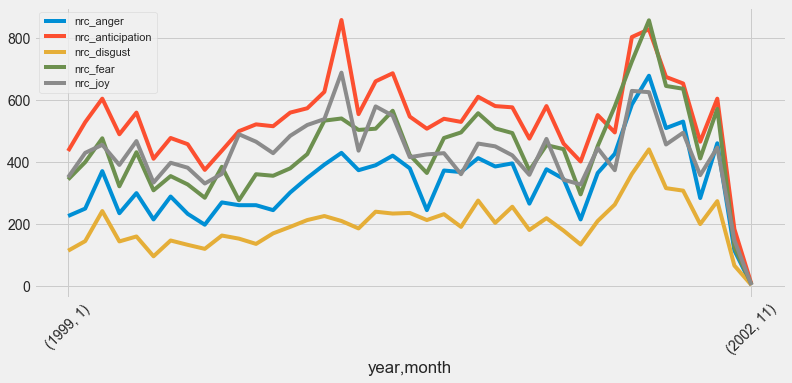

In [127]:
by_Economymonth[emo_cols[:5]].plot(**FIG, xticks=xticks)